# Project

In [267]:
NUM_ITERS = 1000000
DPI_PLOTS = 100
MAX_RUNTIME = 5

In [268]:
# from  sklearn.datasets import load_diabetes
from tensorflow import keras
import math
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [269]:
#data, targets = load_diabetes(return_X_y=True)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
data = np.concatenate((x_train, x_test))
targets = np.concatenate((y_train, y_test))
data = data[np.logical_or(targets == 0, targets == 1)]
targets = targets[np.logical_or(targets == 0, targets == 1)]
data = PCA(n_components=2).fit_transform(MinMaxScaler().fit_transform(data.reshape((data.shape[0], -1))))
#data = np.hstack((data, np.ones((data.shape[0],1))))

$$
s=r \rightarrow 2*\sum_{i=0}^n(x_s^i)x_s^i \\
s\neq r \rightarrow 2*\sum_{i=0}^n(x_r^i)x_s^i
$$

In [270]:
starting_point = np.ones(data.shape[1])

In [271]:
# weights_count = data.shape[1]
# hessian = np.zeros((weights_count, weights_count))
# for i in range(weights_count):
#     for j in range(weights_count):
#         if i == j:
#             hessian[i, j] = data[:,i].T@data[:,i] * 2
#         else:
#             hessian[i, j] = data[:,i].T@data[:,j] * 2
#
# eigenvalues = np.linalg.eig(hessian)[0]
# L = np.max(eigenvalues)
# sigma = np.min(eigenvalues)
# STEPSIZE = 1 / L # 2 / (L + sigma)

## Loss & Grad

In [272]:
def loss_mse(data, targets, w):
    return np.square(data@w - targets).mean()

def grad_mse_array(data, params, targets):
    return -1 / data.shape[0] * data.T @ (targets - data @ params)

def grad_mse_single(sample, params, target):
    return -1 * (target - sample @ params) * sample


def loss_robust_lin_reg_single(data, targets, w):
    return np.log(np.square(targets - data@w)/2 + 1).mean()

def grad_robust_lin_reg_single(sample, w, target):
    temp = 1/((target - sample@w)**2 / 2 + 1) * (target - sample@w)
    return np.array([
        temp * -sample[j]
        for j in range(len(w))
    ])
def grad_robust_lin_reg_array(data, w, targets):
    return np.mean([
        grad_robust_lin_reg_single(data[index], w, targets[index])
        for index in range(len(data))
    ], axis=0)

def loss(data, w, targets):
    return loss_robust_lin_reg_single(data, targets, w)
    #return loss_mse(data, targets, w)

def grad_single(sample, w, target):
    return grad_robust_lin_reg_single(sample, w, target)
    #return grad_mse_single(sample, w, target)

def grad_array(data, w, targets):
    return grad_robust_lin_reg_array(data, w, targets)
    #return grad_mse_array(data, w, targets)

In [273]:
# chunked_data = data.reshape((data.shape[0], -1, data.shape[1]))
# chunked_target = targets.reshape((data.shape[0], -1))

## SGD

In [274]:
w = np.copy(starting_point)
track_mse_sgd = [loss(data, w, targets)]
track_time_sgd = [0]
start =  time.time()
step = 0.01

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    index = np.random.randint(0, data.shape[0])
    w = w - step * grad_single(data[index], w, targets[index])
    step *= .99

    track_time_sgd.append(time.time() - start)
    track_mse_sgd.append(loss(data, w, targets))

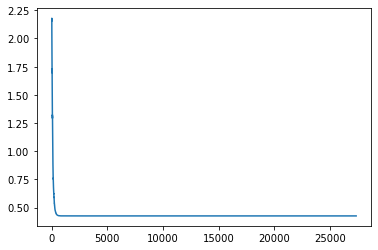

In [275]:
import matplotlib.pyplot as plt
plt.plot(track_mse_sgd)

## SAG

In [276]:
w = np.copy(starting_point)
track_mse_sag = [loss(data, w, targets)]
start =  time.time()
track_time_sag = [0]
g = np.array([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])])
step = 0.001

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    index = np.random.randint(0, data.shape[0])
    g[index] = grad_single(data[index], w, targets[index])
    w = w - step * np.mean(g, axis=0)
    step *= .99

    track_time_sag.append(time.time() - start)
    track_mse_sag.append(loss(data, w, targets))

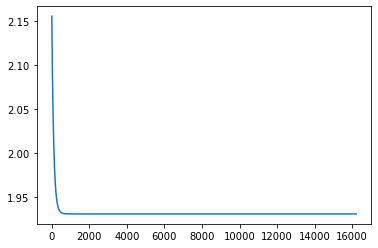

In [277]:
import matplotlib.pyplot as plt
plt.plot(track_mse_sag)

## SAGA

In [278]:
w = np.copy(starting_point)
track_mse_saga = [loss(data, w, targets)]
start =  time.time()
track_time_saga = [0]
g = np.array([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])])
step = 0.01

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    index = np.random.randint(0, data.shape[0])
    gradient = grad_single(data[index], w, targets[index])
    w = w - step * (np.mean(g, axis=0)  - g[index] + gradient)
    g[index] = gradient
    step *= .99

    track_time_saga.append(time.time() - start)
    track_mse_saga.append(loss(data, w, targets))

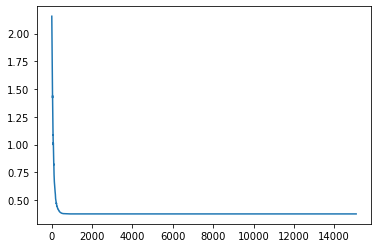

In [279]:
import matplotlib.pyplot as plt
plt.plot(track_mse_saga)

## SVGR

In [280]:
w = np.copy(starting_point)
track_mse_svrg = [loss(data, w, targets)]
start =  time.time()
track_time_svrg = [0]
step = 0.0005

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    w_tilde = np.copy(w)
    avg_gradients = np.mean([grad_single(data[i], w, targets[i]) for i in range(data.shape[0])], axis=0)
    for j in range(data.shape[0] // 2):
        index = np.random.randint(0, data.shape[0])
        current_grad = grad_single(data[index], w, targets[index])
        w = w - step * (
                grad_single(data[index], w, targets[index]) -
                grad_single(data[index], w_tilde, targets[index]) +
                avg_gradients
        )
        track_time_svrg.append(time.time() - start)
        track_mse_svrg.append(loss(data, w, targets))
    step *= .99


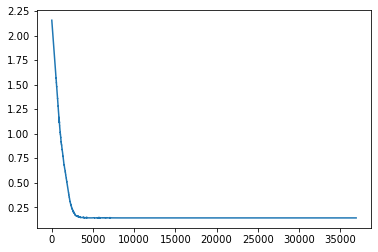

In [281]:
import matplotlib.pyplot as plt
plt.plot(track_mse_svrg)

## SARAH

In [282]:
w = np.copy(starting_point)
track_mse_sarah = [loss(data, w, targets)]
start =  time.time()
track_time_sarah = [0]
step = 0.001

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    w_0 = np.copy(w)
    v_0 = grad_array(data, w, targets)
    w = w_0 - step * v_0
    for t in range(np.random.randint(0, data.shape[0] // 2)):
        index = np.random.randint(0, data.shape[0])
        v_0 = (
                grad_single(data[index], w, targets[index]) -
                grad_single(data[index], w_0, targets[index]) +
                v_0
        )
        w_0 = np.copy(w)
        w = w - step * v_0

        track_time_sarah.append(time.time() - start)
        track_mse_sarah.append(loss(data, w, targets))

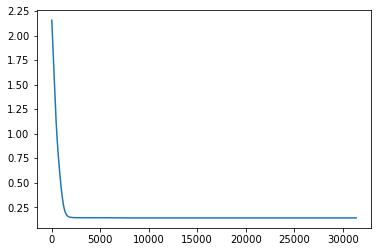

In [283]:
import matplotlib.pyplot as plt
plt.plot(track_mse_sarah)

## SARAH+

In [284]:
w = np.copy(starting_point)
track_mse_sarah_plus = [loss(data, w, targets)]
start =  time.time()
track_time_sarah_plus = [0]
step = 0.01

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    w_0 = np.copy(w)
    v_0 = grad_array(data, w, targets)
    w = w_0 - step * v_0
    v_t = np.copy(v_0)
    for t in range(data.shape[0] // 2):
        if np.linalg.norm(v_t)**2 < 1/8 * (np.linalg.norm(v_0) ** 2):
            break
        index = np.random.randint(0, data.shape[0])
        v_t = (
                grad_single(data[index], w, targets[index]) -
                grad_single(data[index], w_0, targets[index]) +
                v_t
        )
        w_0 = np.copy(w)
        w = w - step * v_t

        track_time_sarah_plus.append(time.time() - start)
        track_mse_sarah_plus.append(loss(data, w, targets))

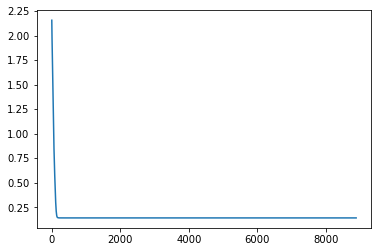

In [285]:
import matplotlib.pyplot as plt
plt.plot(track_mse_sarah_plus)

## SpiderBoost

In [286]:
w = np.copy(starting_point)
w_previous = np.zeros(data.shape[1])

track_mse_spider_boost = [loss(data, w, targets)]
track_time_spider_boost = [0]

start =  time.time()
step = 0.05

q = int(math.sqrt(data.shape[0]))
all_indexes = list(range(data.shape[0]))
v_previous = grad_array(data, w, targets)

for i in range(NUM_ITERS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break
    if  i % q == 0:
        vk = grad_array(data, w, targets)
    else:
        sample_indexes = np.random.choice(all_indexes, q)
        samples_data = data[sample_indexes]
        samples_targets = targets[sample_indexes]

        first = grad_array(samples_data, w, samples_targets)
        second = grad_array(samples_data, w_previous, samples_targets)
        vk = (first - second) + v_previous


    w_previous = np.copy(w)
    v_previous = np.copy(vk)
    w = w - step * vk
    track_time_spider_boost.append(time.time() - start)
    track_mse_spider_boost.append(loss(data, w, targets))

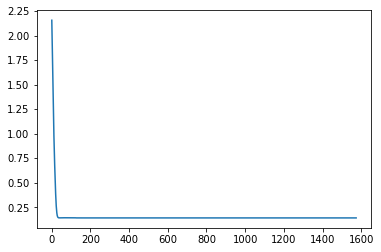

In [287]:
import matplotlib.pyplot as plt
plt.plot(track_mse_spider_boost)

## SNVRG

In [288]:
def updateReferencePoints(wl_old, w, r, K):
    wl_new  = []
    for l in range(r):
        wl_new.append(wl_old[l])
    for l in range(r, K+1):
        wl_new.append(w)
    return np.array(wl_new)

def updateReferenceGradients(gl_old, wl_new, r, K, Bl):
    gl_new  = []
    for l in range(r):
        gl_new.append(gl_old[l])
    for l in range(r, K+1):
        indexes = np.random.choice(list(range(data.shape[0])), Bl, replace=False)
        #print(data[indexes].shape, targets[indexes].shape, wl_new[l].shape)
        gl_new.append(grad_array(data[indexes], wl_new[l], targets[indexes]) - \
                    grad_array(data[indexes], wl_new[l-1], targets[indexes]))
    return gl_new

def oneEpochSNVRG(w, M):
    w = np.copy(w)
    K = 4
    B = 128
    b = 2
    Bl = np.array([B/(b**(i+1)) for i in range(K+1)]).astype("int")
    Tl = np.array([b for _ in range(K+1)])
    wl = np.array([w for _ in range(K+1)])
    wl_previous = np.array([w for _ in range(K+1)])
    wl_history = [[w for _ in range(K+1)]]
    gl = np.array([np.zeros(np.shape(w)).tolist() for _ in range(K+1)])
    indexes = np.random.choice(list(range(data.shape[0])), B, replace=False)
    gl[0] = grad_array(data[indexes], w, targets[indexes])
    v = np.sum(gl, axis=0)
    w = w - 1/(10 * M) * v
    wl_history.append(np.copy(w))
    for t in range(1, np.prod(Tl) - 1):
        r = 0
        for j in range( K + 1):
            if t % np.prod(Tl[j+1:]) == 0:
                r = j
                break
        for l in range(K):
            wl = updateReferencePoints(wl_previous, w, r, K)
        for l in range(K):
            gl = updateReferenceGradients(gl, wl, r, K, Bl[l])

        v = np.sum(gl, axis=0)
        wl_previous = np.copy(wl)
        w = w - 1/(10 * M) * v
        wl_history.append(np.copy(w))

    return wl_history[np.random.randint(wl.shape[0] - 1)], w

In [289]:
w = np.copy(starting_point)
w_previous = np.zeros(data.shape[1])

track_mse_snvrg = [loss(data, w, targets)]
track_time_snvrg = [0]

start =  time.time()
M = 10

for i in range(np.random.randint(NUM_ITERS)):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start:
        break

    y_s, w = oneEpochSNVRG(w, M)

    track_time_snvrg.append(time.time() - start)
    track_mse_snvrg.append(loss(data, w, targets))

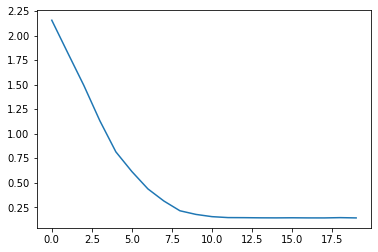

In [290]:
import matplotlib.pyplot as plt
plt.plot(track_mse_snvrg)

## Plots

### Iterations

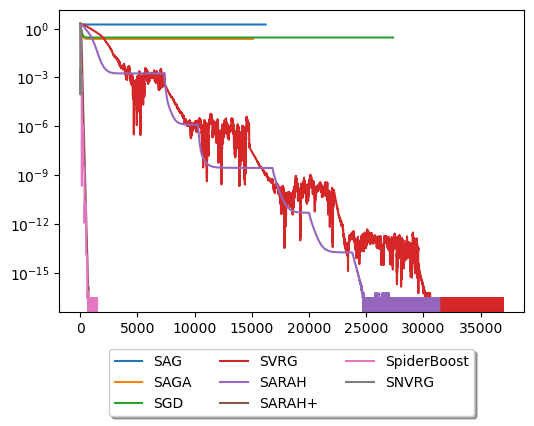

In [291]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)

plt.semilogy(track_mse_sag - np.min(track_mse_sarah))
plt.semilogy(track_mse_saga - np.min(track_mse_sarah))
plt.semilogy(track_mse_sgd - np.min(track_mse_sarah))
plt.semilogy(track_mse_svrg - np.min(track_mse_sarah))
plt.semilogy(track_mse_sarah - np.min(track_mse_sarah))
plt.semilogy(track_mse_sarah_plus - np.min(track_mse_sarah))
plt.semilogy(track_mse_spider_boost - np.min(track_mse_sarah))
plt.semilogy(track_mse_snvrg - np.min(track_mse_sarah))

# Put a legend below current axis
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)


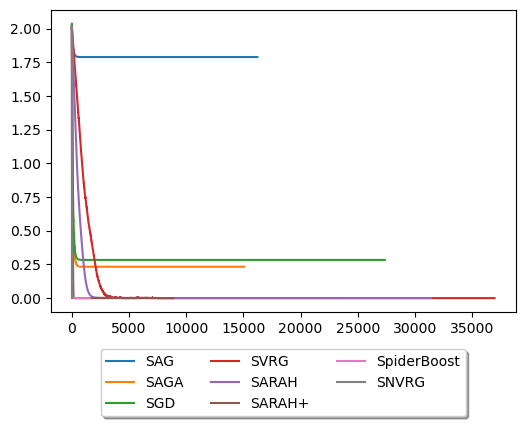

In [292]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_mse_sag - np.min(track_mse_sarah))
plt.plot(track_mse_saga - np.min(track_mse_sarah))
plt.plot(track_mse_sgd - np.min(track_mse_sarah))
plt.plot(track_mse_svrg - np.min(track_mse_sarah))
plt.plot(track_mse_sarah - np.min(track_mse_sarah))
plt.plot(track_mse_sarah_plus - np.min(track_mse_sarah))
plt.plot(track_mse_spider_boost - np.min(track_mse_sarah))
plt.plot(track_mse_snvrg - np.min(track_mse_sarah))
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

### Time

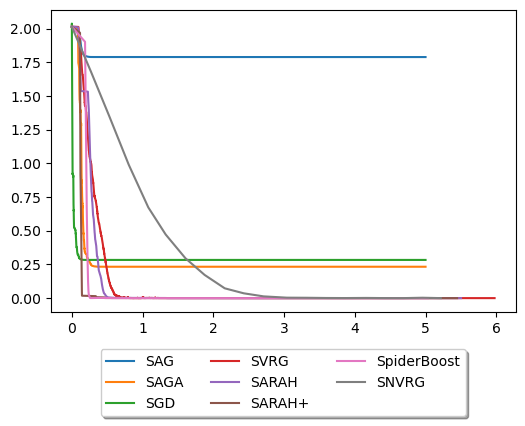

In [293]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_time_sag, track_mse_sag - np.min(track_mse_sarah))
plt.plot(track_time_saga, track_mse_saga - np.min(track_mse_sarah))
plt.plot(track_time_sgd, track_mse_sgd - np.min(track_mse_sarah))
plt.plot(track_time_svrg, track_mse_svrg - np.min(track_mse_sarah))
plt.plot(track_time_sarah, track_mse_sarah - np.min(track_mse_sarah))
plt.plot(track_time_sarah_plus, track_mse_sarah_plus - np.min(track_mse_sarah))
plt.plot(track_time_spider_boost, track_mse_spider_boost - np.min(track_mse_sarah))
plt.plot(track_time_snvrg, track_mse_snvrg - np.min(track_mse_sarah))
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

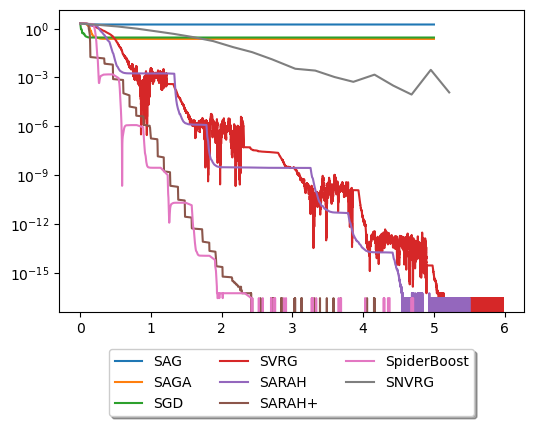

In [294]:
import matplotlib.pyplot as plt
plt.figure(dpi=DPI_PLOTS)
plt.semilogy(track_time_sag, track_mse_sag - np.min(track_mse_sarah))
plt.semilogy(track_time_saga, track_mse_saga - np.min(track_mse_sarah))
plt.semilogy(track_time_sgd, track_mse_sgd - np.min(track_mse_sarah))
plt.semilogy(track_time_svrg, track_mse_svrg - np.min(track_mse_sarah))
plt.semilogy(track_time_sarah, track_mse_sarah - np.min(track_mse_sarah))
plt.semilogy(track_time_sarah_plus, track_mse_sarah_plus - np.min(track_mse_sarah))
plt.semilogy(track_time_spider_boost, track_mse_spider_boost - np.min(track_mse_sarah))
plt.semilogy(track_time_snvrg, track_mse_snvrg - np.min(track_mse_sarah))
plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)